# Phase 1: Data Preprocessing
**Open-Vocabulary Object Detection for Autonomous Surface Vessels**

This notebook prepares all Tier-1 datasets  
(MaSTr1325, MODD, and MODS) for downstream training and evaluation.

---

**Tasks**
1. Verify environment  
2. Auto-detect and extract datasets  
3. Convert MaSTr1325 segmentation masks → bounding boxes  
4. Generate COCO JSONs  
5. Split into train/val/test (70/20/10)  
6. Visualize sample annotations  


### Environment & Package Check

In [1]:
import torch, ultralytics, transformers, os, cv2, json, random, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Ultralytics version:", ultralytics.__version__)
print("Transformers version:", transformers.__version__)

try:
    import groundingdino
    print("GroundingDINO imported successfully ✅")
except ImportError:
    print("⚠️ GroundingDINO not found. Using local clone via PYTHONPATH (expected).")


d:\Sem3\CS581B_Robot_Perception\Project\Implementation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.10.0.dev20251112+cu128
CUDA available: True
Ultralytics version: 8.3.233
Transformers version: 4.57.3
⚠️ GroundingDINO not found. Using local clone via PYTHONPATH (expected).


### Directory Setup

In [2]:
# Ensure BASE_DIR always points to Implementation/
BASE_DIR = Path(__file__).resolve().parent.parent if "__file__" in globals() \
            else Path.cwd().parent

DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
EXTRACTED_DIR = DATA_DIR / "extracted"
ANNOT_DIR = DATA_DIR / "annotations"
PROCESSED_DIR = DATA_DIR / "processed"

print("BASE_DIR:", BASE_DIR)
print("RAW_DIR:", RAW_DIR)
print("RAW_DIR exists:", RAW_DIR.exists())


BASE_DIR: d:\Sem3\CS581B_Robot_Perception\Project\Implementation
RAW_DIR: d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\raw
RAW_DIR exists: True


### Creating Folders

In [3]:
for d in [EXTRACTED_DIR, ANNOT_DIR, PROCESSED_DIR]:
    d.mkdir(parents=True, exist_ok=True)


### DATASETS Dictionary

In [4]:
DATASETS = {
    "mastr": {
        "images_zip": RAW_DIR / "MaSTr1325_images_512x384.zip",
        "masks_zip": RAW_DIR / "MaSTr1325_masks_512x384.zip",
        "images_dir": EXTRACTED_DIR / "MaSTr1325_images_512x384",
        "masks_dir": EXTRACTED_DIR / "MaSTr1325_masks_512x384",
    },
    "modd": {
        "zip": RAW_DIR / "modd_dataset1.0.zip",
        "dir": EXTRACTED_DIR / "modd_dataset1.0",
    },
    "mods": {
        "zip": RAW_DIR / "mods.zip",
        "dir": EXTRACTED_DIR / "mods",
    }
}


### Extraction Logic

In [5]:
import zipfile

def safe_extract(zip_path, extract_dir):
    if not extract_dir.exists():
        print(f"Extracting {zip_path.name} ...")
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(extract_dir)
        print(f"✅ Extracted to {extract_dir}")
    else:
        print(f"⏩ Skipped extraction, {extract_dir.name} already exists.")

# Extract each dataset if needed
for key, paths in DATASETS.items():
    for item in paths.values():
        if str(item).endswith(".zip") and item.exists():
            safe_extract(item, paths.get("dir", EXTRACTED_DIR / key))


⏩ Skipped extraction, mastr already exists.
⏩ Skipped extraction, mastr already exists.
⏩ Skipped extraction, modd_dataset1.0 already exists.
⏩ Skipped extraction, mods already exists.


### Dataset Summaries

In [6]:
def count_files(directory, extensions=(".jpg", ".png")):
    if not Path(directory).exists():
        return 0
    return sum(1 for f in Path(directory).rglob("*") if f.suffix.lower() in extensions)

summary = {
    "MaSTr1325 Images": count_files(DATASETS["mastr"]["images_dir"]),
    "MaSTr1325 Masks": count_files(DATASETS["mastr"]["masks_dir"]),
    "MODD": count_files(DATASETS["modd"]["dir"]),
    "MODS": count_files(DATASETS["mods"]["dir"]),
}
for k, v in summary.items():
    print(f"{k:25s}: {v}")


MaSTr1325 Images         : 1325
MaSTr1325 Masks          : 1325
MODD                     : 726
MODS                     : 24528


### Mask -> Bounding Box Conversion(MaSTr1325)

In [7]:
def masks_to_bboxes(mask_dir, img_dir):
    coco_images, coco_annotations = [], []
    ann_id = 1
    mask_exts = [".png", ".jpg", ".bmp", ".tif"]

    image_files = sorted(Path(img_dir).rglob("*.jpg"))
    print(f"Processing {len(image_files)} images...")

    for img_id, img_path in enumerate(image_files, 1):
        mask_path = None
        for ext in mask_exts:
            # 👇 new logic to handle filenames like 0001m.png
            possible = Path(mask_dir) / f"{img_path.stem}m{ext}"
            if possible.exists():
                mask_path = possible
                break

        if mask_path is None:
            continue  # skip if no matching mask found

        mask = cv2.imread(str(mask_path), 0)
        if mask is None:
            continue

        # Only select obstacle class pixels (value = 2)
        obstacle_mask = np.where(mask == 2, 255, 0).astype(np.uint8)
        contours, _ = cv2.findContours(obstacle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue

        coco_images.append({
            "id": img_id,
            "file_name": img_path.name,
            "width": mask.shape[1],
            "height": mask.shape[0]
        })

        for (x, y, w, h) in [cv2.boundingRect(c) for c in contours]:
            coco_annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": 1,
                "bbox": [int(x), int(y), int(w), int(h)],
                "area": int(w*h),
                "iscrowd": 0
            })
            ann_id += 1

    print(f"✅ Created {len(coco_images)} images and {len(coco_annotations)} boxes.")
    return coco_images, coco_annotations


print("Converting MaSTr1325 masks → bounding boxes ...")
mast_imgs, mast_anns = masks_to_bboxes(
    DATASETS["mastr"]["masks_dir"], DATASETS["mastr"]["images_dir"]
)
print(f"✅ Created {len(mast_imgs)} images and {len(mast_anns)} boxes.")


Converting MaSTr1325 masks → bounding boxes ...
Processing 1325 images...
✅ Created 1325 images and 3424 boxes.
✅ Created 1325 images and 3424 boxes.


### Build COCO Dictionary and Save MaSTr1325 JSON

In [8]:
mast_coco = {
    "images": mast_imgs,
    "annotations": mast_anns,
    "categories": [{"id": 1, "name": "obstacle"}]
}

with open(ANNOT_DIR / "mast_COCO.json", "w") as f:
    json.dump(mast_coco, f, indent=2)
print("✅ Saved:", ANNOT_DIR / "mast_COCO.json")


✅ Saved: d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\annotations\mast_COCO.json


### Visualization

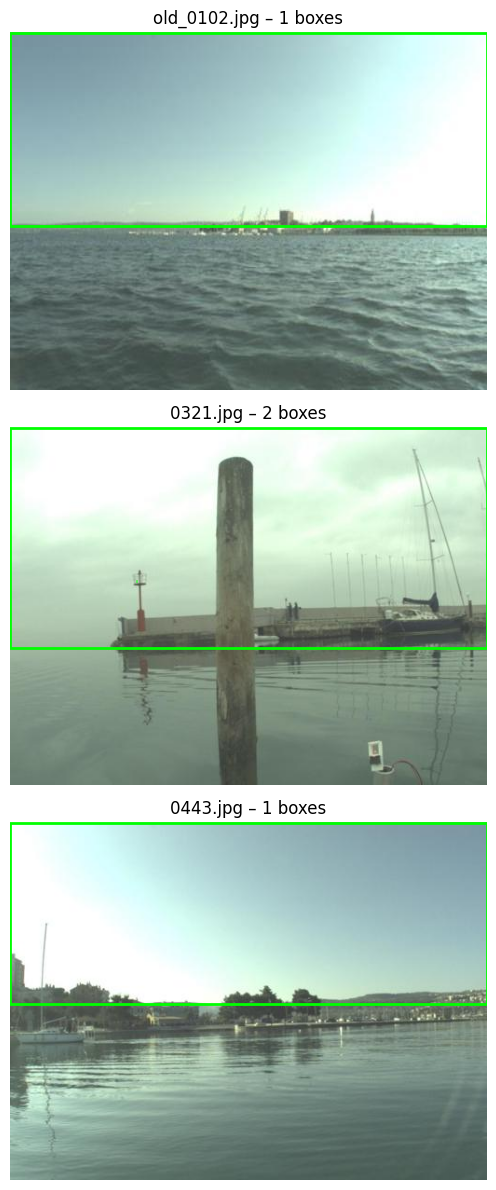

In [9]:
def show_random_samples(img_dir, images, annotations, n=3):
    plt.figure(figsize=(12, 4*n))
    chosen = random.sample(images, min(n, len(images)))
    for i, img_meta in enumerate(chosen, 1):
        img_path = Path(img_dir) / img_meta["file_name"]
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        plt.subplot(n, 1, i)
        plt.imshow(img)
        boxes = [a["bbox"] for a in annotations if a["image_id"] == img_meta["id"]]
        for (x, y, w, h) in boxes:
            plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color="lime", linewidth=2))
        plt.title(f"{img_meta['file_name']} – {len(boxes)} boxes")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


show_random_samples(DATASETS["mastr"]["images_dir"], mast_imgs, mast_anns)


### Placeholder for MODD & MODS COCO Prep

In [10]:
# For now, we only generate MaSTr1325 COCO JSON.
# MODD and MODS often come with existing annotations (check later in Phase 2).
print("📌 Next: MODD/MODS COCO integration will be handled in Phase 2.")


📌 Next: MODD/MODS COCO integration will be handled in Phase 2.


### Train/Val/Test Split

In [11]:
def split_dataset(coco_dict, ratios=(0.7, 0.2, 0.1)):
    imgs = coco_dict["images"]
    random.shuffle(imgs)
    n = len(imgs)
    train_end = int(n * ratios[0])
    val_end = int(n * (ratios[0] + ratios[1]))
    splits = {
        "train": imgs[:train_end],
        "val": imgs[train_end:val_end],
        "test": imgs[val_end:]
    }
    for name, subset in splits.items():
        ids = {img["id"] for img in subset}
        anns = [a for a in coco_dict["annotations"] if a["image_id"] in ids]
        split_dict = {
            "images": subset,
            "annotations": anns,
            "categories": coco_dict["categories"]
        }
        out_path = ANNOT_DIR / f"mast_COCO_{name}.json"
        with open(out_path, "w") as f:
            json.dump(split_dict, f, indent=2)
        print(f"✅ Saved {name} split → {out_path}")
    return splits

splits = split_dataset(mast_coco)


✅ Saved train split → d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\annotations\mast_COCO_train.json
✅ Saved val split → d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\annotations\mast_COCO_val.json
✅ Saved test split → d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\annotations\mast_COCO_test.json


### Wrap-up Summary

In [12]:
print("✅ Preprocessing complete!")
print("Generated files:")
for f in ANNOT_DIR.glob("mast_COCO*.json"):
    print(" -", f.name)

print("\nNext: Proceed to `02_yolov8_baseline.ipynb` for training the closed-set detector.")


✅ Preprocessing complete!
Generated files:
 - mast_COCO.json
 - mast_COCO_test.json
 - mast_COCO_train.json
 - mast_COCO_val.json

Next: Proceed to `02_yolov8_baseline.ipynb` for training the closed-set detector.
